In [1]:
%rm -rf /SimCLRv1-keras-tensorflow

!git clone https://github.com/mwdhont/SimCLRv1-keras-tensorflow.git

Cloning into 'SimCLRv1-keras-tensorflow'...
remote: Enumerating objects: 4925, done.
remote: Counting objects: 100% (4925/4925), done.
remote: Compressing objects: 100% (4884/4884), done.
remote: Total 4925 (delta 75), reused 4882 (delta 38), pack-reused 0
Receiving objects: 100% (4925/4925), 46.30 MiB | 7.16 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [2]:
%ls
%cd SimCLRv1-keras-tensorflow/
!pip install -r requirements.txt

sample_data/  SimCLRv1-keras-tensorflow/
/content/SimCLRv1-keras-tensorflow
     |████████████████████████████████| 7.7MB 6.5MB/s 
     |████████████████████████████████| 421.8MB 25kB/s 
     |████████████████████████████████| 26.3MB 116kB/s 
     |████████████████████████████████| 28.2MB 112kB/s 
     |████████████████████████████████| 6.9MB 46.6MB/s 
     |████████████████████████████████| 20.2MB 1.3MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 450kB 58.2MB/s 
     |████████████████████████████████| 3.9MB 52.6MB/s 
     |████████████████████████████████| 235kB 61.8MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=772e0a9f8cbee7a1f32ccc7d4d08c7283febfe758aadb21cc8dd693aea587220
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: xarray 0.15.1 has requirement

In [1]:
import numpy as np
import pickle
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16 

from SimCLR_Keras.evaluate_features import get_features, linear_classifier, tSNE_vis

# Load Dataframe

In [2]:
df = pd.read_pickle("../data/df.pickle")
df.filename = df.filename.apply(lambda x: f'../{x}')
df.head()

,filename,class_label,class_one_hot
0,../data/processed/plastic/plastic80.jpg,plastic,"[0, 0, 0, 0, 1]"
1,../data/processed/plastic/plastic381.jpg,plastic,"[0, 0, 0, 0, 1]"
2,../data/processed/plastic/plastic169.jpg,plastic,"[0, 0, 0, 0, 1]"
3,../data/processed/plastic/plastic354.jpg,plastic,"[0, 0, 0, 0, 1]"
4,../data/processed/plastic/plastic185.jpg,plastic,"[0, 0, 0, 0, 1]"


In [3]:
class_labels = ["cardboard", "glass", "metal", "paper", "plastic"]
num_classes = len(df['class_one_hot'][0])

print("# of training instances:", len(df.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df.class_label == label).sum()}")

# of training instances: 2390 

# of 'cardboard' training instances: 403
# of 'glass' training instances: 501
# of 'metal' training instances: 410
# of 'paper' training instances: 594
# of 'plastic' training instances: 482


In [4]:
df_train, df_val_test = train_test_split(df, test_size=0.30, random_state=42, shuffle=True)
df_val, df_test = train_test_split(df_val_test, test_size=0.50, random_state=42, shuffle=True)

print("# of training instances:", len(df_train.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df_train.class_label == label).sum()}")
    
print()
print("# of validation instances:", len(df_val.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df_val.class_label == label).sum()}")

print()
print("# of test instances:", len(df_test.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df_test.class_label == label).sum()}")
    
dfs = {
    "train": df_train,
    "val": df_val,
    "test": df_test
}

# of training instances: 1673 

# of 'cardboard' training instances: 299
# of 'glass' training instances: 358
# of 'metal' training instances: 286
# of 'paper' training instances: 405
# of 'plastic' training instances: 325

# of validation instances: 358 

# of 'cardboard' training instances: 47
# of 'glass' training instances: 84
# of 'metal' training instances: 51
# of 'paper' training instances: 100
# of 'plastic' training instances: 76

# of test instances: 359 

# of 'cardboard' training instances: 57
# of 'glass' training instances: 59
# of 'metal' training instances: 73
# of 'paper' training instances: 89
# of 'plastic' training instances: 81


In [5]:
# Img size
size = 80
height_img = size
width_img = size

input_shape = (height_img, width_img, 3)

# Load pretrained VGG16 & Feature evaluation

In [6]:
params_vgg16 = {'weights': "imagenet", 
                'include_top': False, 
                'input_shape': input_shape, 
                'pooling': None}

# Design model
base_model = VGG16(**params_vgg16)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0     

In [7]:
feat_dim = 2 * 2 * 512

# Build SimCLR-Model

In [8]:
from SimCLR_Keras.DataGenerators.DataGeneratorSimCLR import DataGeneratorSimCLR as DataGenerator
from SimCLR_Keras.model import SimCLR

### Properties

In [9]:
batch_size = 32

# Projection_head
num_layers_ph = 2
feat_dims_ph = [2048, 128]
num_of_unfrozen_layers = 1 #Note: with 1, all weights of the base_model are still frozen (last layer is max_pool)
save_path = 'models/trashnet'

In [10]:
SimCLR_model = SimCLR(
        base_model = base_model,
        input_shape = input_shape,
        batch_size = batch_size,
        feat_dims_ph = feat_dims_ph,
        num_of_unfrozen_layers = num_of_unfrozen_layers,
        save_path = save_path
    )

In [23]:
from tensorflow.keras.applications.vgg16 import preprocess_input
params_generator = {'batch_size': batch_size,
                    'shuffle' : True,
                    'width':width_img,
                    'height': height_img,
                    'preprocess_image': preprocess_input
                   }

# Generators
data_train = DataGenerator(df_train.reset_index(drop=True), **params_generator)
data_val = DataGenerator(df_val.reset_index(drop=True), subset = "val", **params_generator) #val keeps the unity values on the same random places ~42
data_test = DataGenerator(df_test.reset_index(drop=True), subset = "test", **params_generator) #test keeps the unity values on the diagonal

In [24]:
y_predict_test_before = SimCLR.predict(data_test)

# SimCLR - Round 1: Only Projection head

## Training SimCLR

In [25]:
SimCLR.train(data_train, data_val, epochs = 5)

Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Epoch 1/5
53/53 [==============================] - ETA: 0s - loss: 382.8240
Epoch 00001: val_loss improved from inf to 328.41324, saving model to models/trashnet/checkpoints/checkpoint__04_07_13h_36.h5
53/53 [==============================] - 33s 616ms/step - loss: 382.8240 - val_loss: 328.4132 - lr: 1.0000e-04
Epoch 2/5
53/53 [==============================] - ETA: 0s - loss: 281.1976
Epoch 00002: val_loss improved from 328.41324 to 234.69441, saving model to models/trashnet/checkpoints/checkpoint__04_07_13h_36.h5
53/53 [==============================] - 28s 521ms/step - loss: 281.1976 - val_loss: 234.6944 - lr: 1.0000e-04
Epoch 3/5
53/53 [==============================] - ETA: 0s - loss: 195.2825
Epoch 00003: val_loss improved from 234.69441 to 156.90709, saving model to models/trashnet/checkpoints/checkpoint__04_07_13h_36.h5
53/53 [==============================] - 28s 522ms/step - los

In [14]:
y_predict_test_after = SimCLR.predict(data_test)

## SimCLR-output check

In [15]:
print(f"Random guess accuracy: {round(1/(2*batch_size),4)}")

print(f"accuracy - test - before: {np.round(np.sum(data_test[0][1] * y_predict_test_before[:batch_size])/(2*batch_size),2)}")
print(f"accuracy - test - after: {np.round(np.sum(data_test[0][1] * y_predict_test_after[:batch_size])/(2*batch_size),2)}")

Random guess accuracy: 0.0156
accuracy - test - before: 0.77
accuracy - test - after: 0.99


In [16]:
print("y_predict_test_before")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_before[i][i],2), end=" | ")
print("\n")    
print("y_predict_test_after")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_after[i][i],2), end=" | ")
print("\n") 
print("y_predict_test_after - Second diagonal")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_after[i + 2 * batch_size][i],2), end=" | ")
print("\n")    

y_predict_test_before
0.72 | 0.83 | 0.83 | 0.79 | 0.8 | 0.74 | 0.79 | 0.87 | 0.63 | 0.81 | 0.77 | 0.74 | 0.83 | 0.78 | 0.71 | 

y_predict_test_after
1.0 | 0.99 | 0.99 | 1.0 | 0.99 | 0.99 | 1.0 | 0.99 | 1.0 | 1.0 | 0.99 | 0.99 | 0.99 | 0.99 | 1.0 | 

y_predict_test_after - Second diagonal
0.99 | 0.99 | 1.0 | 0.99 | 1.0 | 0.99 | 0.99 | 0.99 | 0.99 | 1.0 | 0.99 | 0.99 | 0.99 | 0.99 | 0.99 | 



## Feature Evaluation

Note that this evaluation corresponds with the unaltered pretrained weights

In [17]:
fractions = [1.0, 0.2, 0.05]

### Logistic regression evaluation

In [18]:
features_train, y_train, feats = get_features(base_model, df_train, class_labels)
features_test, y_test, feats = get_features(base_model, df_test, class_labels)
np.count_nonzero(features_train[0])

KeyboardInterrupt: 

In [19]:
# Training logistic regression classifier on 3 fractions of the data
# Optimal regularization is determined from a 5-fold cross-validation
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    linear_classifier(features_train, y_train, features_test, y_test, class_labels, fraction = fraction)

    ==== 100.0% of the training data used ==== 

Accuracy on test: 0.79 

              precision    recall  f1-score   support

   cardboard       0.87      0.84      0.86        57
       glass       0.64      0.78      0.70        59
       metal       0.83      0.71      0.76        73
       paper       0.80      0.89      0.84        89
     plastic       0.81      0.70      0.75        81

    accuracy                           0.79       359
   macro avg       0.79      0.79      0.78       359
weighted avg       0.79      0.79      0.79       359

    ==== 20.0% of the training data used ==== 

Accuracy on test: 0.7 

              precision    recall  f1-score   support

   cardboard       0.90      0.79      0.84        57
       glass       0.55      0.69      0.61        59
       metal       0.69      0.47      0.56        73
       paper       0.70      0.83      0.76        89
     plastic       0.71      0.69      0.70        81

    accuracy                           

### Fine tuned model

In [20]:
%run DataGeneratorClass.py
batch_size_classifier = 32
params_generator_classifier = {'max_width':width_img,
                            'max_height': height_img,
                            'num_classes': num_classes,
                            'preprocess_input': preprocess_input
                            }
params_training_classifier = {'1.0':{
                                "reg_dense" : 0.005,
                                "reg_out" : 0.005,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 15, 10]
                                },
                              '0.2':{
                                "reg_dense" : 0.075,
                                "reg_out" : 0.01,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 20, 15]
                              },
                              '0.05':{
                                "reg_dense" : 0.01,
                                "reg_out" : 0.02,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 1e-5],
                                "epochs" : [5, 5, 20, 15]
                              }                              
                            }

In [21]:
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    SimCLR.train_NL_and_evaluate(dfs = dfs,
                                batch_size = batch_size_classifier,
                                params_generator = params_generator_classifier,
                                fraction = fraction,
                                class_labels = class_labels,
                                reg_dense = params_training_classifier[str(fraction)]["reg_dense"],
                                reg_out = params_training_classifier[str(fraction)]["reg_out"],
                                nums_of_unfrozen_layers = params_training_classifier[str(fraction)]["nums_of_unfrozen_layers"],
                                lrs = params_training_classifier[str(fraction)]["lrs"],
                                epochs = params_training_classifier[str(fraction)]["epochs"],
                                verbose_epoch = 0,
                                verbose_cycle = 0
                                )

    ==== 100.0% of the training data used ==== 

Best result from attempt 4
              precision    recall  f1-score   support

   cardboard       0.90      0.91      0.90        57
       glass       0.87      0.81      0.84        59
       metal       0.87      0.85      0.86        73
       paper       0.90      0.90      0.90        89
     plastic       0.77      0.81      0.79        81

    accuracy                           0.86       359
   macro avg       0.86      0.86      0.86       359
weighted avg       0.86      0.86      0.86       359

    ==== 20.0% of the training data used ==== 

Learning diverged, stopped.
Learning diverged, stopped.
Learning diverged, stopped.
Learning diverged, stopped.
Best result from attempt 2
              precision    recall  f1-score   support

   cardboard       0.96      0.81      0.88        57
       glass       0.79      0.78      0.79        59
       metal       0.81      0.74      0.77        73
       paper       0.77      0.

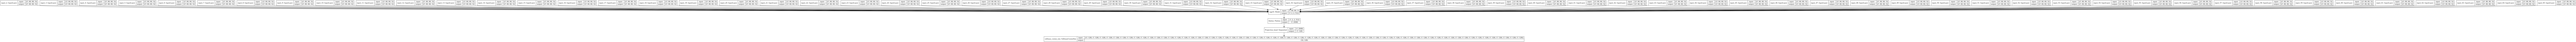

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(
    SimCLR.SimCLR_model,
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    to_file='./model_architecture.png'
)

### SimCLR.SimCLR_model.get_layer

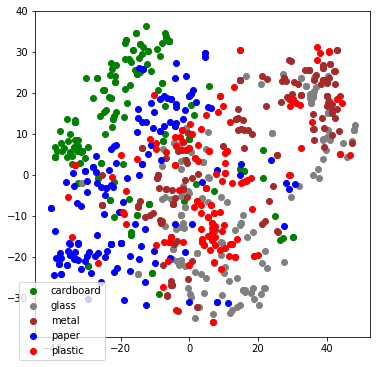

In [22]:
tSNE_vis(df_train, features_train, class_labels)

# SimCLR - Round 2: Unfreeze last convolutional layer

## Training SimCLR

In [24]:
#Unfreeze
SimCLR.unfreeze_and_train(data_train, data_val, num_of_unfrozen_layers = 2, r = 2, lr = 1e-5, epochs = 5)   

trainable parameters: 6.82 M.
non-trainable parameters: 12.35 M.
Epoch 1/5
53/53 [==============================] - ETA: 0s - loss: 47.8214
Epoch 00001: val_loss improved from inf to 45.81333, saving model to models/trashnet/SimCLR/SimCLR_03_26_15h_28.h5
53/53 [==============================] - 66s 1s/step - loss: 47.8214 - val_loss: 45.8133 - lr: 1.0000e-05
Epoch 2/5
53/53 [==============================] - ETA: 0s - loss: 44.2731
Epoch 00002: val_loss improved from 45.81333 to 42.54144, saving model to models/trashnet/SimCLR/SimCLR_03_26_15h_28.h5
53/53 [==============================] - 64s 1s/step - loss: 44.2731 - val_loss: 42.5414 - lr: 1.0000e-05
Epoch 3/5
53/53 [==============================] - ETA: 0s - loss: 41.0760
Epoch 00003: val_loss improved from 42.54144 to 39.42237, saving model to models/trashnet/SimCLR/SimCLR_03_26_15h_28.h5
53/53 [==============================] - 60s 1s/step - loss: 41.0760 - val_loss: 39.4224 - lr: 1.0000e-05
Epoch 4/5
53/53 [====================

## Feature Evaluation

### Logisitic regression

In [25]:
base_model = SimCLR.base_model
fractions = [1.0, 0.2, 0.05]

In [26]:
features_train, y_train, feats = get_features(base_model, df_train, class_labels)
features_test, y_test, feats = get_features(base_model, df_test, class_labels)
np.count_nonzero(features_train[0])

819

In [27]:
# Training logistic regression classifier on 3 fractions of the data
# Optimal regularization is determined from a 5-fold cross-validation
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    linear_classifier(features_train, y_train, features_test, y_test, class_labels, fraction = fraction)

    ==== 100.0% of the training data used ==== 

Accuracy on test: 0.82 

              precision    recall  f1-score   support

   cardboard       0.94      0.82      0.88        57
       glass       0.82      0.76      0.79        59
       metal       0.81      0.85      0.83        73
       paper       0.79      0.90      0.84        89
     plastic       0.82      0.77      0.79        81

    accuracy                           0.82       359
   macro avg       0.83      0.82      0.83       359
weighted avg       0.83      0.82      0.82       359

    ==== 20.0% of the training data used ==== 

Accuracy on test: 0.81 

              precision    recall  f1-score   support

   cardboard       0.92      0.82      0.87        57
       glass       0.72      0.75      0.73        59
       metal       0.80      0.82      0.81        73
       paper       0.80      0.90      0.85        89
     plastic       0.82      0.73      0.77        81

    accuracy                          

### Fine tuned model

In [28]:
batch_size_classifier = 32
params_generator_classifier = {'max_width':width_img,
                            'max_height': height_img,
                            'num_classes': num_classes,
                            'VGG': True
                            }
params_training_classifier = {'1.0':{
                                "reg_dense" : 0.005,
                                "reg_out" : 0.005,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 15, 10]
                                },
                              '0.2':{
                                "reg_dense" : 0.075,
                                "reg_out" : 0.01,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 20, 15]
                              },
                              '0.05':{
                                "reg_dense" : 0.01,
                                "reg_out" : 0.02,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 1e-5],
                                "epochs" : [5, 5, 20, 15]
                              }                              
                            }

In [29]:
for fraction in fractions:    
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    SimCLR.train_NL_and_evaluate(dfs = dfs,
                                batch_size = batch_size_classifier,
                                params_generator = params_generator_classifier,
                                fraction = fraction,
                                class_labels = class_labels,
                                reg_dense = params_training_classifier[str(fraction)]["reg_dense"],
                                reg_out = params_training_classifier[str(fraction)]["reg_out"],
                                nums_of_unfrozen_layers = params_training_classifier[str(fraction)]["nums_of_unfrozen_layers"],
                                lrs = params_training_classifier[str(fraction)]["lrs"],
                                epochs = params_training_classifier[str(fraction)]["epochs"],
                                verbose_epoch = 0,
                                verbose_cycle = 0
                                )

    ==== 100.0% of the training data used ==== 

Learning diverged, stopped.
Learning diverged, stopped.
Learning diverged, stopped.
Learning diverged, stopped.
Learning diverged, stopped.
Best result from attempt 1
None
    ==== 20.0% of the training data used ==== 

Learning diverged, stopped.
Learning diverged, stopped.
Learning diverged, stopped.
Learning diverged, stopped.
Learning diverged, stopped.
Best result from attempt 4
              precision    recall  f1-score   support

   cardboard       0.89      0.86      0.88        57
       glass       0.94      0.56      0.70        59
       metal       0.81      0.78      0.80        73
       paper       0.78      0.93      0.85        89
     plastic       0.74      0.84      0.79        81

    accuracy                           0.81       359
   macro avg       0.83      0.79      0.80       359
weighted avg       0.82      0.81      0.80       359

    ==== 5.0% of the training data used ==== 

Learning diverged, stopped.


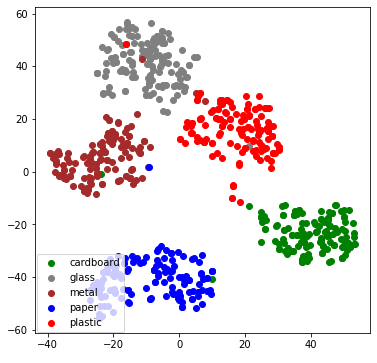

In [31]:
tSNE_vis(df_train, features_train, class_labels)

# SimCLR - Round 3: Unfreeze 2 last convolutional layer

## Training SimCLR

In [32]:
#Unfreeze
SimCLR.unfreeze_and_train(data_train, data_val, num_of_unfrozen_layers = 3, r = 3, lr = 5e-6, epochs = 5)   

trainable parameters: 9.18 M.
non-trainable parameters: 10.0 M.
Train for 53 steps, validate for 12 steps
Epoch 1/5
52/53 [============================>.] - ETA: 1s - loss: 58.1905
Epoch 00001: val_loss improved from inf to 56.99666, saving model to models/trashnet/SimCLR/SimCLR_07_25_10h_04.h5
53/53 [==============================] - 86s 2s/step - loss: 58.1696 - val_loss: 56.9967
Epoch 2/5
52/53 [============================>.] - ETA: 0s - loss: 56.4327
Epoch 00002: val_loss improved from 56.99666 to 55.72707, saving model to models/trashnet/SimCLR/SimCLR_07_25_10h_04.h5
53/53 [==============================] - 59s 1s/step - loss: 56.4221 - val_loss: 55.7271
Epoch 3/5
52/53 [============================>.] - ETA: 0s - loss: 55.2348
Epoch 00003: val_loss improved from 55.72707 to 54.56079, saving model to models/trashnet/SimCLR/SimCLR_07_25_10h_04.h5
53/53 [==============================] - 59s 1s/step - loss: 55.2233 - val_loss: 54.5608
Epoch 4/5
52/53 [============================>.

In [33]:
y_predict_test_after = SimCLR.predict(data_test)

## Feature Evaluation

In [34]:
base_model = SimCLR.base_model

In [35]:
features_train, y_train, feats = get_features(base_model, df_train, class_labels)
features_test, y_test, feats = get_features(base_model, df_test, class_labels)
np.count_nonzero(features_train[0])

846

In [36]:
# Training logistic regression classifier on 3 fractions of the data
# Optimal regularization is determined from a 5-fold cross-validation
fractions = [1.0, 0.2, 0.05]
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    linear_classifier(features_train, y_train, features_test, y_test, class_labels, fraction = fraction)

    ==== 100.0% of the training data used ==== 

Accuracy on test: 0.84 

              precision    recall  f1-score   support

   cardboard       0.87      0.93      0.90        57
       glass       0.75      0.80      0.77        59
       metal       0.83      0.88      0.85        73
       paper       0.91      0.88      0.89        89
     plastic       0.83      0.74      0.78        81

    accuracy                           0.84       359
   macro avg       0.84      0.84      0.84       359
weighted avg       0.84      0.84      0.84       359

    ==== 20.0% of the training data used ==== 

Accuracy on test: 0.83 

              precision    recall  f1-score   support

   cardboard       0.87      0.93      0.90        57
       glass       0.73      0.80      0.76        59
       metal       0.80      0.82      0.81        73
       paper       0.88      0.88      0.88        89
     plastic       0.84      0.73      0.78        81

    accuracy                          

### Fine tuned model

In [37]:
batch_size_classifier = 32
params_generator_classifier = {'max_width':width_img,
                            'max_height': height_img,
                            'num_classes': num_classes,
                            'VGG': True
                        }

In [38]:
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    SimCLR.train_NL_and_evaluate(dfs = dfs,
                                batch_size = batch_size_classifier,
                                params_generator = params_generator_classifier,
                                fraction = fraction,
                                class_labels = class_labels,
                                reg_dense = 0.005,
                                reg_out = 0.003,
                                nums_of_unfrozen_layers = [5, 5, 6, 7],
                                lrs = [1e-3, 1e-4, 5e-5, 1e-5],
                                epochs = [5, 5, 15, 10],
                                verbose_epoch = 0,
                                verbose_cycle = 0
                                )

    ==== 100.0% of the training data used ==== 

Best result from attempt 3
              precision    recall  f1-score   support

   cardboard       0.96      0.91      0.94        57
       glass       0.81      0.85      0.83        59
       metal       0.81      0.89      0.85        73
       paper       0.87      0.92      0.90        89
     plastic       0.87      0.74      0.80        81

    accuracy                           0.86       359
   macro avg       0.86      0.86      0.86       359
weighted avg       0.86      0.86      0.86       359

    ==== 20.0% of the training data used ==== 

Best result from attempt 3
              precision    recall  f1-score   support

   cardboard       0.88      0.91      0.90        57
       glass       0.83      0.83      0.83        59
       metal       0.82      0.85      0.83        73
       paper       0.91      0.92      0.92        89
     plastic       0.87      0.80      0.83        81

    accuracy                      

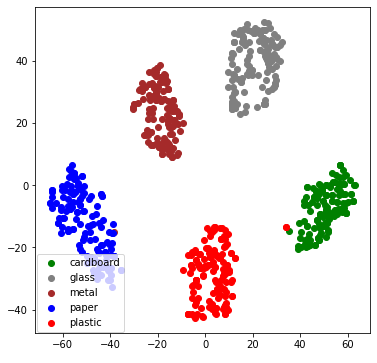

In [39]:
tSNE_vis(df_train, features_train, class_labels)

# SimCLR - Round 4: Unfreeze 3 last convolutional layer

In [40]:
y_predict_test_before = y_predict_test_after

## Training SimCLR

In [41]:
#Unfreeze
SimCLR.unfreeze_and_train(data_train, 
                          data_val, 
                          num_of_unfrozen_layers = 4, 
                          r = 4, 
                          lr = 1e-6, 
                          epochs = 5)  

trainable parameters: 11.54 M.
non-trainable parameters: 7.64 M.
Train for 53 steps, validate for 12 steps
Epoch 1/5
52/53 [============================>.] - ETA: 1s - loss: 53.7285
Epoch 00001: val_loss improved from inf to 52.67540, saving model to models/trashnet/SimCLR/SimCLR_07_25_10h_23.h5
53/53 [==============================] - 90s 2s/step - loss: 53.7145 - val_loss: 52.6754
Epoch 2/5
52/53 [============================>.] - ETA: 1s - loss: 52.6048
Epoch 00002: val_loss improved from 52.67540 to 52.33002, saving model to models/trashnet/SimCLR/SimCLR_07_25_10h_23.h5
53/53 [==============================] - 63s 1s/step - loss: 52.6012 - val_loss: 52.3300
Epoch 3/5
52/53 [============================>.] - ETA: 1s - loss: 52.3287
Epoch 00003: val_loss improved from 52.33002 to 52.18499, saving model to models/trashnet/SimCLR/SimCLR_07_25_10h_23.h5
53/53 [==============================] - 63s 1s/step - loss: 52.3261 - val_loss: 52.1850
Epoch 4/5
52/53 [============================>

In [42]:
y_predict_test_after = SimCLR.predict(data_test)

## Feature Evaluation

### Logistic Regression

In [43]:
base_model = SimCLR.base_model

In [44]:
features_train, y_train, feats = get_features(base_model, df_train, class_labels)
features_test, y_test, feats = get_features(base_model, df_test, class_labels)
np.count_nonzero(features_train[0])

1103

In [45]:
# Training logistic regression classifier on 3 fractions of the data
# Optimal regularization is determined from a 5-fold cross-validation
fractions = [1.0, 0.2, 0.05]
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    linear_classifier(features_train, y_train, features_test, y_test, class_labels, fraction = fraction)

    ==== 100.0% of the training data used ==== 

Accuracy on test: 0.83 

              precision    recall  f1-score   support

   cardboard       0.90      0.82      0.86        57
       glass       0.80      0.80      0.80        59
       metal       0.79      0.90      0.84        73
       paper       0.84      0.89      0.86        89
     plastic       0.83      0.72      0.77        81

    accuracy                           0.83       359
   macro avg       0.83      0.83      0.83       359
weighted avg       0.83      0.83      0.83       359

    ==== 20.0% of the training data used ==== 

Accuracy on test: 0.82 

              precision    recall  f1-score   support

   cardboard       0.92      0.84      0.88        57
       glass       0.77      0.80      0.78        59
       metal       0.79      0.85      0.82        73
       paper       0.81      0.89      0.85        89
     plastic       0.83      0.73      0.78        81

    accuracy                          

### Fine tuned model

In [46]:
batch_size_classifier = 32
params_generator_classifier = {'max_width':width_img,
                            'max_height': height_img,
                            'num_classes': num_classes,
                            'VGG': True
                            }
params_training_classifier = {'1.0':{
                                "reg_dense" : 0.005,
                                "reg_out" : 0.005,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 15, 10]
                                },
                              '0.2':{
                                "reg_dense" : 0.075,
                                "reg_out" : 0.01,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 20, 15]
                              },
                              '0.05':{
                                "reg_dense" : 0.01,
                                "reg_out" : 0.02,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 1e-5],
                                "epochs" : [5, 5, 20, 15]
                              }                              
                            }

In [47]:
for fraction in fractions:    
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    SimCLR.train_NL_and_evaluate(dfs = dfs,
                                batch_size = batch_size_classifier,
                                params_generator = params_generator_classifier,
                                fraction = fraction,
                                class_labels = class_labels,
                                reg_dense = params_training_classifier[str(fraction)]["reg_dense"],
                                reg_out = params_training_classifier[str(fraction)]["reg_out"],
                                nums_of_unfrozen_layers = params_training_classifier[str(fraction)]["nums_of_unfrozen_layers"],
                                lrs = params_training_classifier[str(fraction)]["lrs"],
                                epochs = params_training_classifier[str(fraction)]["epochs"],
                                verbose_epoch = 0,
                                verbose_cycle = 0
                                )

    ==== 100.0% of the training data used ==== 

Best result from attempt 3
              precision    recall  f1-score   support

   cardboard       0.96      0.91      0.94        57
       glass       0.85      0.88      0.87        59
       metal       0.81      0.89      0.85        73
       paper       0.90      0.94      0.92        89
     plastic       0.92      0.80      0.86        81

    accuracy                           0.89       359
   macro avg       0.89      0.89      0.89       359
weighted avg       0.89      0.89      0.89       359

    ==== 20.0% of the training data used ==== 

Best result from attempt 1
              precision    recall  f1-score   support

   cardboard       0.90      0.95      0.92        57
       glass       0.83      0.83      0.83        59
       metal       0.81      0.86      0.83        73
       paper       0.92      0.92      0.92        89
     plastic       0.90      0.81      0.86        81

    accuracy                      

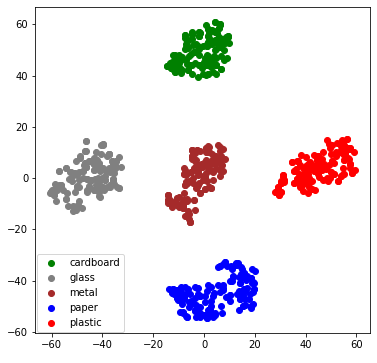

In [48]:
tSNE_vis(df_train, features_train, class_labels)